In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import datetime
import numpy as np
from utils_3D import Q, rmsre  # Changed from utils_2D to utils_3D

In [3]:
# set precision (default is 'float32')
K.set_floatx('float64')

In [4]:
def load_data(fname):
    data = np.load(fname, allow_pickle=True)
    feq   = data['f_eq']
    fpre  = data['f_pre']
    fpost = data['f_post']
    return feq, fpre, fpost

###########################################################
# O_h Symmetry Group for D3Q19 (48 transformations)
# Generated from 24 rotations of the cube + inversion
###########################################################

# All 48 permutations for O_h symmetry group applied to D3Q19 stencil
OH_PERMS = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    [0, 1, 2, 5, 6, 4, 3, 15, 16, 17, 18, 13, 11, 14, 12, 8, 7, 10, 9],
    [0, 6, 5, 3, 4, 1, 2, 12, 14, 11, 13, 7, 9, 8, 10, 16, 18, 15, 17],
    [0, 3, 4, 2, 1, 5, 6, 9, 7, 10, 8, 17, 18, 15, 16, 11, 12, 13, 14],
    [0, 1, 2, 4, 3, 6, 5, 8, 7, 10, 9, 14, 13, 12, 11, 16, 15, 18, 17],
    [0, 3, 4, 5, 6, 1, 2, 11, 12, 13, 14, 15, 17, 16, 18, 7, 9, 8, 10],
    [0, 5, 6, 2, 1, 4, 3, 17, 15, 18, 16, 10, 9, 8, 7, 13, 11, 14, 12],
    [0, 6, 5, 1, 2, 4, 3, 16, 18, 15, 17, 8, 7, 10, 9, 14, 12, 13, 11],
    [0, 2, 1, 3, 4, 6, 5, 9, 10, 7, 8, 12, 11, 14, 13, 18, 17, 16, 15],
    [0, 6, 5, 2, 1, 3, 4, 18, 16, 17, 15, 9, 10, 7, 8, 12, 14, 11, 13],
    [0, 2, 1, 4, 3, 5, 6, 10, 9, 8, 7, 13, 14, 11, 12, 17, 18, 15, 16],
    [0, 1, 2, 6, 5, 3, 4, 16, 15, 18, 17, 12, 14, 11, 13, 7, 8, 9, 10],
    [0, 5, 6, 4, 3, 1, 2, 13, 11, 14, 12, 8, 10, 7, 9, 15, 17, 16, 18],
    [0, 4, 3, 2, 1, 6, 5, 10, 8, 9, 7, 18, 17, 16, 15, 14, 13, 12, 11],
    [0, 3, 4, 1, 2, 6, 5, 7, 9, 8, 10, 16, 15, 18, 17, 12, 11, 14, 13],
    [0, 2, 1, 5, 6, 3, 4, 17, 18, 15, 16, 11, 13, 12, 14, 9, 10, 7, 8],
    [0, 2, 1, 6, 5, 4, 3, 18, 17, 16, 15, 14, 12, 13, 11, 10, 9, 8, 7],
    [0, 6, 5, 4, 3, 2, 1, 14, 12, 13, 11, 10, 8, 9, 7, 18, 16, 17, 15],
    [0, 5, 6, 3, 4, 2, 1, 11, 13, 12, 14, 9, 7, 10, 8, 17, 15, 18, 16],
    [0, 4, 3, 1, 2, 5, 6, 8, 10, 7, 9, 15, 16, 17, 18, 13, 14, 11, 12],
    [0, 4, 3, 6, 5, 1, 2, 14, 13, 12, 11, 16, 18, 15, 17, 8, 10, 7, 9],
    [0, 5, 6, 1, 2, 3, 4, 15, 17, 16, 18, 7, 8, 9, 10, 11, 13, 12, 14],
    [0, 3, 4, 6, 5, 2, 1, 12, 11, 14, 13, 18, 16, 17, 15, 9, 7, 10, 8],
    [0, 4, 3, 5, 6, 2, 1, 13, 14, 11, 12, 17, 15, 18, 16, 10, 8, 9, 7],
    [0, 2, 1, 4, 3, 6, 5, 10, 9, 8, 7, 14, 13, 12, 11, 18, 17, 16, 15],
    [0, 2, 1, 6, 5, 3, 4, 18, 17, 16, 15, 12, 14, 11, 13, 9, 10, 7, 8],
    [0, 5, 6, 4, 3, 2, 1, 13, 11, 14, 12, 10, 8, 9, 7, 17, 15, 18, 16],
    [0, 4, 3, 1, 2, 6, 5, 8, 10, 7, 9, 16, 15, 18, 17, 14, 13, 12, 11],
    [0, 2, 1, 3, 4, 5, 6, 9, 10, 7, 8, 11, 12, 13, 14, 17, 18, 15, 16],
    [0, 4, 3, 6, 5, 2, 1, 14, 13, 12, 11, 18, 16, 17, 15, 10, 8, 9, 7],
    [0, 6, 5, 1, 2, 3, 4, 16, 18, 15, 17, 7, 8, 9, 10, 12, 14, 11, 13],
    [0, 5, 6, 2, 1, 3, 4, 17, 15, 18, 16, 9, 10, 7, 8, 11, 13, 12, 14],
    [0, 1, 2, 4, 3, 5, 6, 8, 7, 10, 9, 13, 14, 11, 12, 15, 16, 17, 18],
    [0, 5, 6, 1, 2, 4, 3, 15, 17, 16, 18, 8, 7, 10, 9, 13, 11, 14, 12],
    [0, 1, 2, 3, 4, 6, 5, 7, 8, 9, 10, 12, 11, 14, 13, 16, 15, 18, 17],
    [0, 2, 1, 5, 6, 4, 3, 17, 18, 15, 16, 13, 11, 14, 12, 10, 9, 8, 7],
    [0, 6, 5, 3, 4, 2, 1, 12, 14, 11, 13, 9, 7, 10, 8, 18, 16, 17, 15],
    [0, 3, 4, 1, 2, 5, 6, 7, 9, 8, 10, 15, 16, 17, 18, 11, 12, 13, 14],
    [0, 4, 3, 2, 1, 5, 6, 10, 8, 9, 7, 17, 18, 15, 16, 13, 14, 11, 12],
    [0, 1, 2, 6, 5, 4, 3, 16, 15, 18, 17, 14, 12, 13, 11, 8, 7, 10, 9],
    [0, 1, 2, 5, 6, 3, 4, 15, 16, 17, 18, 11, 13, 12, 14, 7, 8, 9, 10],
    [0, 5, 6, 3, 4, 1, 2, 11, 13, 12, 14, 7, 9, 8, 10, 15, 17, 16, 18],
    [0, 6, 5, 4, 3, 1, 2, 14, 12, 13, 11, 8, 10, 7, 9, 16, 18, 15, 17],
    [0, 3, 4, 2, 1, 6, 5, 9, 7, 10, 8, 18, 17, 16, 15, 12, 11, 14, 13],
    [0, 3, 4, 5, 6, 2, 1, 11, 12, 13, 14, 17, 15, 18, 16, 9, 7, 10, 8],
    [0, 6, 5, 2, 1, 4, 3, 18, 16, 17, 15, 10, 9, 8, 7, 14, 12, 13, 11],
    [0, 4, 3, 5, 6, 1, 2, 13, 14, 11, 12, 15, 17, 16, 18, 8, 10, 7, 9],
    [0, 3, 4, 6, 5, 1, 2, 12, 11, 14, 13, 16, 18, 15, 17, 7, 9, 8, 10],
]

# Inverse permutations for O_h symmetry group
OH_INV_PERMS = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    [0, 1, 2, 6, 5, 3, 4, 16, 15, 18, 17, 12, 14, 11, 13, 7, 8, 9, 10],
    [0, 5, 6, 3, 4, 2, 1, 11, 13, 12, 14, 9, 7, 10, 8, 17, 15, 18, 16],
    [0, 4, 3, 1, 2, 5, 6, 8, 10, 7, 9, 15, 16, 17, 18, 13, 14, 11, 12],
    [0, 1, 2, 4, 3, 6, 5, 8, 7, 10, 9, 14, 13, 12, 11, 16, 15, 18, 17],
    [0, 5, 6, 1, 2, 3, 4, 15, 17, 16, 18, 7, 8, 9, 10, 11, 13, 12, 14],
    [0, 4, 3, 6, 5, 1, 2, 14, 13, 12, 11, 16, 18, 15, 17, 8, 10, 7, 9],
    [0, 3, 4, 6, 5, 2, 1, 12, 11, 14, 13, 18, 16, 17, 15, 9, 7, 10, 8],
    [0, 2, 1, 3, 4, 6, 5, 9, 10, 7, 8, 12, 11, 14, 13, 18, 17, 16, 15],
    [0, 4, 3, 5, 6, 2, 1, 13, 14, 11, 12, 17, 15, 18, 16, 10, 8, 9, 7],
    [0, 2, 1, 4, 3, 5, 6, 10, 9, 8, 7, 13, 14, 11, 12, 17, 18, 15, 16],
    [0, 1, 2, 5, 6, 4, 3, 15, 16, 17, 18, 13, 11, 14, 12, 8, 7, 10, 9],
    [0, 5, 6, 4, 3, 1, 2, 13, 11, 14, 12, 8, 10, 7, 9, 15, 17, 16, 18],
    [0, 4, 3, 2, 1, 6, 5, 10, 8, 9, 7, 18, 17, 16, 15, 14, 13, 12, 11],
    [0, 3, 4, 1, 2, 6, 5, 7, 9, 8, 10, 16, 15, 18, 17, 12, 11, 14, 13],
    [0, 2, 1, 5, 6, 3, 4, 17, 18, 15, 16, 11, 13, 12, 14, 9, 10, 7, 8],
    [0, 2, 1, 6, 5, 4, 3, 18, 17, 16, 15, 14, 12, 13, 11, 10, 9, 8, 7],
    [0, 6, 5, 4, 3, 2, 1, 14, 12, 13, 11, 10, 8, 9, 7, 18, 16, 17, 15],
    [0, 6, 5, 3, 4, 1, 2, 12, 14, 11, 13, 7, 9, 8, 10, 16, 18, 15, 17],
    [0, 3, 4, 2, 1, 5, 6, 9, 7, 10, 8, 17, 18, 15, 16, 11, 12, 13, 14],
    [0, 5, 6, 2, 1, 4, 3, 17, 15, 18, 16, 10, 9, 8, 7, 13, 11, 14, 12],
    [0, 3, 4, 5, 6, 1, 2, 11, 12, 13, 14, 15, 17, 16, 18, 7, 9, 8, 10],
    [0, 6, 5, 1, 2, 4, 3, 16, 18, 15, 17, 8, 7, 10, 9, 14, 12, 13, 11],
    [0, 6, 5, 2, 1, 3, 4, 18, 16, 17, 15, 9, 10, 7, 8, 12, 14, 11, 13],
    [0, 2, 1, 4, 3, 6, 5, 10, 9, 8, 7, 14, 13, 12, 11, 18, 17, 16, 15],
    [0, 2, 1, 5, 6, 4, 3, 17, 18, 15, 16, 13, 11, 14, 12, 10, 9, 8, 7],
    [0, 6, 5, 4, 3, 1, 2, 14, 12, 13, 11, 8, 10, 7, 9, 16, 18, 15, 17],
    [0, 3, 4, 2, 1, 6, 5, 9, 7, 10, 8, 18, 17, 16, 15, 12, 11, 14, 13],
    [0, 2, 1, 3, 4, 5, 6, 9, 10, 7, 8, 11, 12, 13, 14, 17, 18, 15, 16],
    [0, 6, 5, 2, 1, 4, 3, 18, 16, 17, 15, 10, 9, 8, 7, 14, 12, 13, 11],
    [0, 3, 4, 5, 6, 2, 1, 11, 12, 13, 14, 17, 15, 18, 16, 9, 7, 10, 8],
    [0, 4, 3, 5, 6, 1, 2, 13, 14, 11, 12, 15, 17, 16, 18, 8, 10, 7, 9],
    [0, 1, 2, 4, 3, 5, 6, 8, 7, 10, 9, 13, 14, 11, 12, 15, 16, 17, 18],
    [0, 3, 4, 6, 5, 1, 2, 12, 11, 14, 13, 16, 18, 15, 17, 7, 9, 8, 10],
    [0, 1, 2, 3, 4, 6, 5, 7, 8, 9, 10, 12, 11, 14, 13, 16, 15, 18, 17],
    [0, 2, 1, 6, 5, 3, 4, 18, 17, 16, 15, 12, 14, 11, 13, 9, 10, 7, 8],
    [0, 6, 5, 3, 4, 2, 1, 12, 14, 11, 13, 9, 7, 10, 8, 18, 16, 17, 15],
    [0, 3, 4, 1, 2, 5, 6, 7, 9, 8, 10, 15, 16, 17, 18, 11, 12, 13, 14],
    [0, 4, 3, 2, 1, 5, 6, 10, 8, 9, 7, 17, 18, 15, 16, 13, 14, 11, 12],
    [0, 1, 2, 6, 5, 4, 3, 16, 15, 18, 17, 14, 12, 13, 11, 8, 7, 10, 9],
    [0, 1, 2, 5, 6, 3, 4, 15, 16, 17, 18, 11, 13, 12, 14, 7, 8, 9, 10],
    [0, 5, 6, 3, 4, 1, 2, 11, 13, 12, 14, 7, 9, 8, 10, 15, 17, 16, 18],
    [0, 5, 6, 4, 3, 2, 1, 13, 11, 14, 12, 10, 8, 9, 7, 17, 15, 18, 16],
    [0, 4, 3, 1, 2, 6, 5, 8, 10, 7, 9, 16, 15, 18, 17, 14, 13, 12, 11],
    [0, 6, 5, 1, 2, 3, 4, 16, 18, 15, 17, 7, 8, 9, 10, 12, 14, 11, 13],
    [0, 4, 3, 6, 5, 2, 1, 14, 13, 12, 11, 18, 16, 17, 15, 10, 8, 9, 7],
    [0, 5, 6, 2, 1, 3, 4, 17, 15, 18, 16, 9, 10, 7, 8, 11, 13, 12, 14],
    [0, 5, 6, 1, 2, 4, 3, 15, 17, 16, 18, 8, 7, 10, 9, 13, 11, 14, 12],
]

def apply_permutation(f, perm):
    """Apply a permutation to the velocity indices of f.
    f has shape (batch, 19), perm is a list of 19 indices."""
    return tf.gather(f, perm, axis=-1)


class OhSymmetry(tf.keras.layers.Layer):
    """Apply all 48 O_h symmetry operations to D3Q19 distributions."""
    def __init__(self, **kwargs):
        super(OhSymmetry, self).__init__(**kwargs)
        # Convert permutations to TensorFlow constants
        self.perms = [tf.constant(p, dtype=tf.int32) for p in OH_PERMS]

    def call(self, x):
        return [apply_permutation(x, perm) for perm in self.perms]


class OhAntiSymmetry(tf.keras.layers.Layer):
    """Apply inverse O_h symmetry operations to restore original orientation."""
    def __init__(self, **kwargs):
        super(OhAntiSymmetry, self).__init__(**kwargs)
        # Convert inverse permutations to TensorFlow constants
        self.inv_perms = [tf.constant(p, dtype=tf.int32) for p in OH_INV_PERMS]

    def call(self, x):
        return [apply_permutation(x[i], self.inv_perms[i]) for i in range(48)]


class AlgReconstruction3D(tf.keras.layers.Layer):
    """Algebraic reconstruction for D3Q19 to enforce conservation laws.
    
    Conservation constraints (4 equations):
      - Mass: sum(df) = 0
      - Momentum-x: sum(df * cx) = 0
      - Momentum-y: sum(df * cy) = 0
      - Momentum-z: sum(df * cz) = 0
    
    Reconstructed indices: 0, 1, 3, 5 (rest, +x, +y, +z)
    Free indices: 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18 (15 components)
    """
    def __init__(self, **kwargs):
        super(AlgReconstruction3D, self).__init__(**kwargs)

    def call(self, fpre, fpred):
        # Compute difference
        df = fpred - fpre
        
        # Reconstruct df0, df1, df3, df5 from conservation constraints
        # These formulas derived by solving the 4 conservation equations
        
        # df1 = df2 - df7 - df8 + df9 + df10 - df15 - df16 + df17 + df18
        df1_new = (df[:,2] - df[:,7] - df[:,8] + df[:,9] + df[:,10] 
                   - df[:,15] - df[:,16] + df[:,17] + df[:,18])
        
        # df3 = df4 - df7 + df8 - df9 + df10 - df11 - df12 + df13 + df14
        df3_new = (df[:,4] - df[:,7] + df[:,8] - df[:,9] + df[:,10] 
                   - df[:,11] - df[:,12] + df[:,13] + df[:,14])
        
        # df5 = df6 - df11 + df12 - df13 + df14 - df15 + df16 - df17 + df18
        df5_new = (df[:,6] - df[:,11] + df[:,12] - df[:,13] + df[:,14] 
                   - df[:,15] + df[:,16] - df[:,17] + df[:,18])
        
        # df0 = -(all others) after substituting df1, df3, df5
        # df0 = -2*df2 - 2*df4 - 2*df6 + df7 - df8 - df9 - 3*df10 
        #       + df11 - df12 - df13 - 3*df14 + df15 - df16 - df17 - 3*df18
        df0_new = (-2.0*df[:,2] - 2.0*df[:,4] - 2.0*df[:,6] 
                   + df[:,7] - df[:,8] - df[:,9] - 3.0*df[:,10]
                   + df[:,11] - df[:,12] - df[:,13] - 3.0*df[:,14]
                   + df[:,15] - df[:,16] - df[:,17] - 3.0*df[:,18])
        
        # Concatenate in correct order: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
        df_reconstructed = tf.concat([
            df0_new[:, None],   # 0 (reconstructed)
            df1_new[:, None],   # 1 (reconstructed)
            df[:, 2, None],     # 2 (free)
            df3_new[:, None],   # 3 (reconstructed)
            df[:, 4, None],     # 4 (free)
            df5_new[:, None],   # 5 (reconstructed)
            df[:, 6, None],     # 6 (free)
            df[:, 7, None],     # 7 (free)
            df[:, 8, None],     # 8 (free)
            df[:, 9, None],     # 9 (free)
            df[:, 10, None],    # 10 (free)
            df[:, 11, None],    # 11 (free)
            df[:, 12, None],    # 12 (free)
            df[:, 13, None],    # 13 (free)
            df[:, 14, None],    # 14 (free)
            df[:, 15, None],    # 15 (free)
            df[:, 16, None],    # 16 (free)
            df[:, 17, None],    # 17 (free)
            df[:, 18, None],    # 18 (free)
        ], axis=-1)
        
        return fpre + df_reconstructed

In [5]:
def sequential_model(Q=19, n_hidden_layers=2, n_per_layer=50, activation="relu", 
                     ll_activation="linear", bias=False):
    """Base sequential model for D3Q19 (19 input/output components)."""
    model = Sequential()
    
    model.add(Dense(n_per_layer, input_shape=(Q,), activation=activation, 
                    use_bias=bias, kernel_initializer="he_uniform"))
    
    for jj in range(n_hidden_layers):
        model.add(Dense(n_per_layer, activation=activation, 
                        use_bias=bias, kernel_initializer="he_uniform"))
    
    model.add(Dense(Q, activation=ll_activation, 
                    use_bias=bias, kernel_initializer="he_uniform"))

    return model 


def create_model_3D(loss="mape", optimizer="adam", Q=19, 
                    n_hidden_layers=2, n_per_layer=50, activation="relu", 
                    ll_activation="linear", bias=False):
    """Create physics-informed neural network for D3Q19 collision operator.
    
    Architecture:
    1. Input (19 components)
    2. OhSymmetry: Apply all 48 O_h symmetry operations
    3. Sequential NN: Process each symmetry variant
    4. AlgReconstruction3D: Enforce conservation laws
    5. OhAntiSymmetry: Reverse symmetry operations
    6. Average: Combine all 48 predictions
    """
    the_input = keras.Input(shape=(Q,))

    seq_model = sequential_model(Q, n_hidden_layers, n_per_layer, 
                                 activation, ll_activation, bias)
    
    # Apply 48 O_h symmetry transformations
    input_lst = OhSymmetry()(the_input)
    
    # Process each transformed input through the same network
    output_lst = [seq_model(x) for x in input_lst]

    # Apply algebraic reconstruction to enforce conservation
    output_lst = [AlgReconstruction3D()(input_lst[k], x) for k, x in enumerate(output_lst)]

    # Apply inverse symmetry transformations
    output_lst = OhAntiSymmetry()(output_lst)
    
    # Average over all 48 symmetry operations
    the_output = layers.Average()(output_lst)

    model = keras.Model(inputs=the_input, outputs=the_output)
    model.compile(loss=loss, optimizer=optimizer)    
    
    return model

In [6]:
###########################################################
# D3Q19 Physics-Informed Neural Network
#
# Key components:
# - Q = 19 velocity components
# - O_h symmetry group with 48 transformations (24 rotations x 2 for inversion)
# - 4 conservation constraints (mass + 3 momentum components)
# - 15 free parameters learned by NN, 4 reconstructed algebraically
#
# Architecture follows Prins thesis (2022) methodology extended to 3D:
# 1. Apply all 48 O_h symmetries to input
# 2. Process through shared sequential NN
# 3. Enforce conservation via algebraic reconstruction
# 4. Reverse symmetry operations
# 5. Average predictions for final output
###########################################################

In [7]:
# Read 3D training dataset
feq, fpre, fpost = load_data('example_dataset_3D.npz')

print(f"Dataset shape: {fpre.shape}")
print(f"Number of samples: {fpre.shape[0]}")
print(f"Number of velocity components (Q): {fpre.shape[1]}")

# Normalize data on density (scale invariance)
feq   = feq   / np.sum(feq, axis=1)[:, np.newaxis]
fpre  = fpre  / np.sum(fpre, axis=1)[:, np.newaxis]
fpost = fpost / np.sum(fpost, axis=1)[:, np.newaxis]

# Split train and test set (70/30)
fpre_train, fpre_test, fpost_train, fpost_test = train_test_split(
    fpre, fpost, test_size=0.3, shuffle=True, random_state=42
)

print(f"Training samples: {fpre_train.shape[0]}")
print(f"Test samples: {fpre_test.shape[0]}")

Dataset shape: (100000, 19)
Number of samples: 100000
Number of velocity components (Q): 19
Training samples: 70000
Test samples: 30000


In [8]:
# Training hyperparameters
batch_size = 32
n_epochs = 200
patience = 50
verbose = 1

# Create 3D model with O_h symmetry (48 augmentations)
model = create_model_3D(loss=rmsre, ll_activation="softmax")

print("Model summary:")
model.summary()

# EarlyStopping callback
es_callback = EarlyStopping(
    monitor="val_loss", 
    patience=patience, 
    restore_best_weights=True
)

# Save best weights during training
ck_callback = ModelCheckpoint(
    filepath="weights_3D.keras",  # Changed from weights_2D.keras
    monitor="val_loss", 
    save_best_only=True
)

keras_callbacks = [es_callback, ck_callback]

# Train the model
print("\nStarting training...")
hist = model.fit(
    fpre_train, fpost_train, 
    epochs=n_epochs, 
    verbose=verbose, 
    callbacks=keras_callbacks, 
    validation_data=(fpre_test, fpost_test), 
    batch_size=batch_size
)

/Users/owner/Projects/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ oh_symmetry         │ [(None, 19),      │          0 │ input_layer[0][0] │
│ (OhSymmetry)        │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                 

 Total params: 6,900 (53.91 KB)

 Trainable params: 6,900 (53.91 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
Epoch 1/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - loss: 0.0240 - val_loss: 0.0061
Epoch 2/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 3/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 5/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0015 - val_loss: 9.7150e-04
Epoch 6/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0013 - val_loss: 3.2028e-04
Epoch 9/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 10/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0013 - val_loss: 9.5788e-04
Epoch 11/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss:

In [9]:
# Load best weights and save complete model
model.load_weights("weights_3D.keras")
model.save("example_network_3D.keras")
print("Model saved to example_network_3D.keras")

Model saved to example_network_3D.keras


In [10]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss = model.evaluate(fpre_test, fpost_test)
print(f"\nFinal test loss (RMSRE): {test_loss:.6e}")

Evaluating model on test set...
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - loss: 2.4844e-04

Final test loss (RMSRE): 2.484355e-04


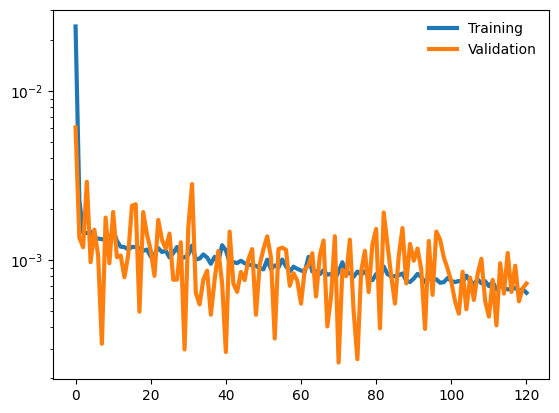

In [11]:
import matplotlib.pyplot as plt

plt.semilogy( hist.history['loss']    , lw=3, label='Training'   )
plt.semilogy( hist.history['val_loss'], lw=3, label='Validation' )

plt.legend(loc='best', frameon=False)

plt.show()